In [2]:
from collections import Counter
import os
from glob import glob
import re

from graphviz import Source
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import networkx as nx
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter



sns.set_style('white')
sns.set_context('notebook')

def plot_style(figsize=(12, 6), labelsize=20, titlesize=24, ticklabelsize=14, **kwargs):
   basic_style = {
       'figure.figsize': figsize,
       'axes.labelsize': labelsize,
       'axes.titlesize': titlesize,
       'xtick.labelsize': ticklabelsize,
       'ytick.labelsize': ticklabelsize,
       'axes.spines.top': False,
       'axes.spines.right': False,
       'axes.spines.left': False,
       'axes.grid': False,
       'axes.grid.axis': 'y',
   }
   basic_style.update(kwargs)
   return plt.rc_context(rc=basic_style)

blue = sns.xkcd_rgb['ocean blue']

In [3]:
# fixa std path osv for tree5, change notebook name

## Create df with performance data

### Clone map

In [4]:
data = pd.read_csv('../../data/simulated_clone_key/simulated_clone_key_10clones.txt', sep = '\t')
data.head()

clones_map_raw = data.copy()

In [5]:
#clones_map_raw

In [6]:
clones_map = dict(clones_map_raw[['tree_id', 'clone']].values)
all_clones = list(clones_map_raw.clone.unique())

In [7]:
n_samples_per_clone = clones_map_raw.clone.value_counts()
n_samples_per_clone

1     10
2     10
3     10
4     10
5     10
6     10
7     10
8     10
9     10
10    10
Name: clone, dtype: int64

### Load tree and pmat data

In [8]:
exp = 'tree5'

In [33]:
scite_input_path = f'../../../mt-SCITE/mt-SCITE_output/Simulations/non-informative_mutations/tree5/stdout/'

scite_stdout_filenames = list(glob(os.path.join(scite_input_path, '*.txt')))

# Get log likelihood scores and n trees
experiments = []
lhood = []
n_trees = []

for filename in sorted(scite_stdout_filenames, key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)]):
    #name = os.path.basename(filename).split('-')[0].rsplit('.', 2)[0]
    name = os.path.basename(filename).rsplit('.')[0]
    #print(name)
    experiments.append(name)
    file = open(filename, "r")
    for line in file:
        if 'best log score for tree:' in line:
            score = line.split('	')[1].rstrip()
            lhood.append(score)
            lhood = [float(x) for x in lhood]
        if 'opt tree' in line:
            n = line.split(' opt')[0].lstrip()
            n_trees.append(n)
            n_trees = [int(x) for x in n_trees]
            

In [34]:
# non-informative positions and cells sharing non-informative positions            
n_ni_pos = []
n_cells_w_ni_pos = []

for i in experiments:
    i = i.split('_')
    #print(i)
    n_cells_w_ni_pos.append(i[1]) # cells sharing non-informative postions
    n_ni_pos.append(i[3]) # non-informative positions
#print(experiments)

In [35]:
# Get n rows in pmat
pmat_input_path = f'../../data/simulations_matrix_output/non-informative/tree5/'

pmats = list(glob(os.path.join(pmat_input_path, '*.csv')))

n_pmat_rows = []
for filename in sorted(pmats, key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)]):
    #print(filename)
    file = open(filename, "r")
    n = len(file.readlines())
    n_pmat_rows.append(n)

### Create df

In [36]:
samples = 100

performance = pd.DataFrame(experiments)
performance['lhood'] = lhood
performance['lhood'] = performance['lhood'].astype(float)

performance['n trees'] = n_trees

performance['n_pmat_rows'] = n_pmat_rows # n rows in pmat

performance['entries'] = performance['n_pmat_rows']*samples

performance['lhood_entries'] = performance['lhood']/performance['entries']
performance = performance.rename(columns={0: 'error_rate'})
performance = performance.set_index('error_rate')
    
performance['n_ni_pos'] = n_ni_pos
performance['n_cells_w_ni_pos'] = n_cells_w_ni_pos

#performance['n_cells_w_ni_pos_frac'] = (performance['n_cells_w_ni_pos'].astype(int) / samples).round(2).astype(str)
performance['n_ni_pos_frac'] = (performance['n_ni_pos'].astype(int) / performance['n_pmat_rows'].astype(int)).round(2)*100


# error rates refers to experiments with added non-informative positions
error_rates = performance.index.tolist()
n_trees = performance['n trees'].tolist()
#error_rates, n_trees


In [76]:
pd.set_option('display.max_rows', None)

In [38]:
performance.shape

(14000, 8)

### Read trees

In [ ]:
# for f in */*/*.newick; do echo rm "$f"; done
# for f in */*/*.newick; do rm "$f"; done

# for f in */*/*gv; do rsync --remove-source-files -rvp "$f" all_dot_files; done          

In [40]:
MAX_TREES_PER_ERROR_RATE = 10
all_trees = {}
for error_rate, n in zip(error_rates, n_trees):
    all_trees[error_rate] = []
    for idx in range(min(MAX_TREES_PER_ERROR_RATE, n)):
        #print(n)
        tree_filename = f'../../../mt-SCITE/mt-SCITE_output/Simulations/non-informative_mutations/tree5/all_dot_files/{error_rate}_map{idx}.gv' 
        tree = nx.drawing.nx_pydot.read_dot(tree_filename)
        tree.remove_node('\\n')
        all_trees[error_rate].append(tree)
        #print(error_rate)

In [41]:
def new_count_row(all_clone_names, clone_name=None):
    """ Create a DataFrame row with one entry per clone name. 
    
    If `clone_name` is not None, initialize that entry to 1.
    """
    row = pd.Series(data=0, index=all_clone_names)
    if clone_name is not None:
        row[clone_name] = 1
    return row

def dfs_clones_count(g, clones, all_clone_names, source_node):
    clones_count = pd.DataFrame({sample_name: new_count_row(all_clones, clone_name) for sample_name, clone_name in clones.items()})
    for pre_node, post_node, edge_label in nx.dfs_labeled_edges(g, source_node):
        if edge_label is not 'reverse' or pre_node == post_node: 
            continue
        pre_node_counter = clones_count.get(pre_node, new_count_row(all_clones))
        if post_node not in clones_count.columns:
            print('!! possible mutation in a leaf: not found', post_node)
            continue
        clones_count[pre_node] = pre_node_counter + clones_count[post_node]

    return clones_count

def purity(clones_count):
    return clones_count.div(clones_count.sum(axis=0), axis=1)

def get_root_node(t):
    root_nodes = [n for n,d in t.in_degree() if d==0]
    assert len(root_nodes) == 1
    root_node = root_nodes[0]
    return root_node

<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_29969/661853690.py:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if edge_label is not 'reverse' or pre_node == post_node:


# Avg purity of nodes with >1 sample

In [42]:
performance['avg_purity_more_than_one_sample'] = 0
performance['frac_purity_100_more_than_one_sample'] = 0
for error_rate, trees in all_trees.items():
    avg_purities = []
    frac_purities_100 = []
    n_purities_100 = []
    for t in trees:
        #print(error_rate, get_root_node(t))
        #print(error_rate)
        #print(get_root_node(t))
        
        #print(root_node)
        clones_count = dfs_clones_count(t, clones_map, all_clones, source_node=get_root_node(t))
        
        # which nodes have more than one sample
        more_than_one_sample = clones_count.sum(axis=0) > 1
        #print(more_than_one_sample)
        
        # p is a matrix with rows = clones and columns = nodes.
        # included nodes are those attached to > 1 sample
        # the values in p are the clone purities in each node
        p = purity(clones_count).loc[:, more_than_one_sample]
        # print p before root node is removed
        #print(p)
        
        # Drop root node since it is attached to all samples
        # Get the root node
        root_node = str(get_root_node(t))
        # Get the index of the root node
        root_idx = list(p.columns).index(root_node)
        #print(root_idx)
        # drop the root node 
        p = p.drop(p.columns[[root_idx]],axis = 1)
        # Check that root node is removed
        #print(p)
        
        # Average purity
        avg_purity = p.max(axis=0).mean()
        avg_purities.append(avg_purity)
        #print(avg_purities)
        # Fraction of nodes with 100% purity
        is_purity_100 = np.isclose(p.max(axis=0), 1.0)
        frac_purity_100 = is_purity_100.sum() / is_purity_100.shape[0]
        frac_purities_100.append(frac_purity_100)
        
    performance.loc[error_rate, 'avg_purity_more_than_one_sample'] = avg_purities[0]
    performance.loc[error_rate, 'frac_purity_100_more_than_one_sample'] = frac_purities_100[0]

In [43]:
performance

,lhood,n trees,n_pmat_rows,entries,lhood_entries,n_ni_pos,n_cells_w_ni_pos,n_ni_pos_frac,avg_purity_more_than_one_sample,frac_purity_100_more_than_one_sample
error_rate,,,,,,,,,,
tree5_2_cells_1_pos_1_iter,-5.847666,1,6,600,-0.009746,1,2,17.0,1.000000,1.000000
tree5_2_cells_1_pos_2_iter,-5.847666,1,6,600,-0.009746,1,2,17.0,1.000000,1.000000
tree5_2_cells_1_pos_3_iter,-5.847666,1,6,600,-0.009746,1,2,17.0,1.000000,1.000000
tree5_2_cells_1_pos_4_iter,-5.847666,1,6,600,-0.009746,1,2,17.0,1.000000,1.000000
tree5_2_cells_1_pos_5_iter,-5.847666,1,6,600,-0.009746,1,2,17.0,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...
tree5_8_cells_20_pos_96_iter,-457.931573,2,25,2500,-0.183173,20,8,80.0,0.761333,0.560000
tree5_8_cells_20_pos_97_iter,-457.544806,10,25,2500,-0.183018,20,8,80.0,0.759333,0.560000
tree5_8_cells_20_pos_98_iter,-457.711912,7,25,2500,-0.183085,20,8,80.0,0.777083,0.541667


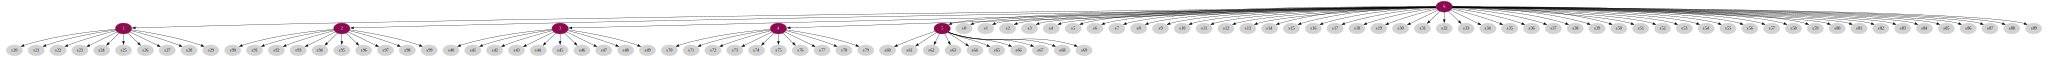

In [17]:
# Plot ground truth tree

Source.from_file(f'../../../mt-SCITE/mt-SCITE_output/Simulations/ground_truth/tree5_map0.gv')


# Clone coverage at full purity

In [44]:
# clones with mut = 3, 10, 5, 8, 7,   
# clones w/o mut = 1, 2, 4, 6, 9


performance['min_clone_coverage'] = np.nan
performance['avg_clone_coverage'] = np.nan
for error_rate, trees in all_trees.items():
    t = trees[0]
    clones_count = dfs_clones_count(t, clones_map, all_clones, source_node=get_root_node(t))
    #print(clones_count)
    p = purity(clones_count)
    is_pure = p.max(axis=0) == 1.0
    #print(is_pure)
    coverage_per_clone = clones_count.loc[:, is_pure].div(n_samples_per_clone, axis=0).max(axis=1)
    #print(coverage_per_clone)
    
    #print(coverage_per_clone)
    #print(error_rate, '\n', coverage_per_clone, '\n---')
    min_coverage = coverage_per_clone.min()
    
    # drop clones w/o clone mut
    avg_coverage = coverage_per_clone.drop([1, 2, 4, 6, 9], axis=0).mean()
    
    
    performance.loc[error_rate, 'min_clone_coverage'] = min_coverage
    performance.loc[error_rate, 'avg_clone_coverage'] = avg_coverage

# Plots

In [46]:
# Plot an example tree
#Source.from_file('../../../mt-SCITE/mt-SCITE_output/Simulations/tree1/6_cells/tree1_6_cells_10_pos_map0.gv')

In [49]:
len(performance)

14000

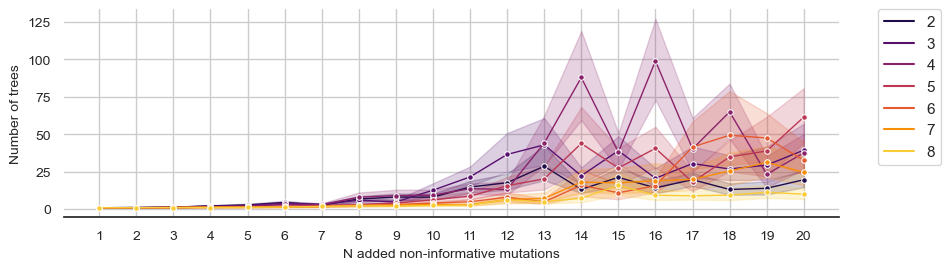

In [47]:
with plot_style(figsize=(10, 2.7), ticklabelsize=10, labelsize=10):
    sns.lineplot(data=performance, x="n_ni_pos", y="n trees", hue = 'n_cells_w_ni_pos', palette='inferno', marker='o', markersize=4, lw=1)
    plt.grid(axis='both')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel('Number of trees')
    plt.xlabel('N added non-informative mutations')

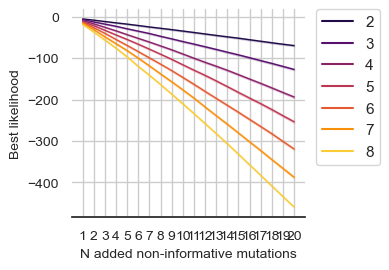

In [80]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    sns.lineplot(data=performance, x="n_ni_pos", y="lhood", hue = 'n_cells_w_ni_pos', palette='inferno', markersize=4, lw=1) #marker='o'
    plt.grid(axis='both')
    ax.set_xlim(0, 20)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel('Best likelihood')
    plt.xlabel('N added non-informative mutations')
    
plt.savefig(f'../../data/simulated_figures/lhood_{exp}.svg', dpi=300, bbox_inches='tight', transparent=True)
plt.savefig(f'../../data/simulated_figures/lhood_{exp}.jpg', dpi=300, bbox_inches='tight', transparent=True)

## Average purity

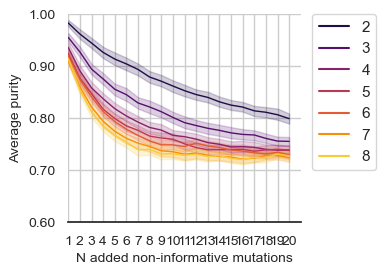

In [82]:

with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    ax = sns.lineplot(data=performance, x="n_ni_pos", y="avg_purity_more_than_one_sample", hue = 'n_cells_w_ni_pos', palette='inferno', markersize=4, lw=1)
    ax.set_ylim(0.6, 1)
    plt.grid(axis='both')
    #plt.xlim(0, 15)
    ax.set_xlim(0, 20)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    #tick = 1
    #[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % tick != 0]
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel('Average purity')
    plt.xlabel('N added non-informative mutations')
    
    
plt.savefig(f'../../data/simulated_figures/avg_purity_{exp}.svg', dpi=300, bbox_inches='tight', transparent=True)
plt.savefig(f'../../data/simulated_figures/avg_purity_{exp}.jpg', dpi=300, bbox_inches='tight', transparent=True)

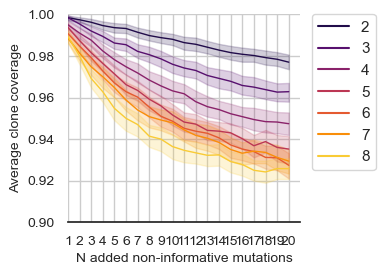

In [83]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    ax = sns.lineplot(data=performance, x="n_ni_pos", y="avg_clone_coverage", hue = 'n_cells_w_ni_pos', palette='inferno', markersize=4, lw=1) #ci=None
    ax.set_ylim(0.9, 1)
    plt.grid(axis='both')
    ax.set_xlim(0, 20)
    #tick = 4
    #[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % tick != 0]
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel('Average clone coverage')
    plt.xlabel('N added non-informative mutations')
    
plt.savefig(f'../../data/simulated_figures/clone_coverage_{exp}.svg', dpi=300, bbox_inches='tight', transparent=True)
plt.savefig(f'../../data/simulated_figures/clone_coverage_{exp}.jpg', dpi=300, bbox_inches='tight', transparent=True)

In [26]:
# PROPS = {
#     'boxprops':{'facecolor':'none', 'edgecolor':'black'},
#     'medianprops':{'color':'black'},
#     'whiskerprops':{'color':'black'},
#     'capprops':{'color':'black'}
# }


# with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
#     ax = sns.boxplot(data=performance, x="n_ni_pos", y="avg_clone_coverage", **PROPS, linewidth=0.5, showfliers=False) #legend=None
#     #sns.scatterplot(data=performance, x="n_ni_pos", y="avg_clone_coverage", palette='inferno', hue = 'n_cells_w_ni_pos', s=30, edgecolor='black') #legend=None
#     plt.grid(axis='both')
#     plt.ylim(0, 1.05)
#     tick = 2
#     [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % tick != 0]
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.ylabel('Average clone coverage')
#     plt.xlabel('N added non-informative mutations')

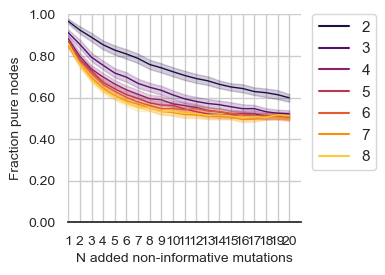

In [77]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    ax = sns.lineplot(data=performance, x="n_ni_pos", y="frac_purity_100_more_than_one_sample", hue = 'n_cells_w_ni_pos', palette='inferno', markersize=4, lw=1)
    ax.set_ylim(0, 1)
    plt.grid(axis='both')
    #plt.xlim(0, 15)
    ax.set_xlim(0, 20)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    #tick = 1
    #[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % tick != 0]
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel('Fraction pure nodes')
    plt.xlabel('N added non-informative mutations')
    
plt.savefig(f'../../data/simulated_figures/fraction_pure_nodes_{exp}.svg', dpi=300, bbox_inches='tight', transparent=True)
plt.savefig(f'../../data/simulated_figures/fraction_pure_nodes_{exp}.jpg', dpi=300, bbox_inches='tight', transparent=True)

In [28]:
#performance

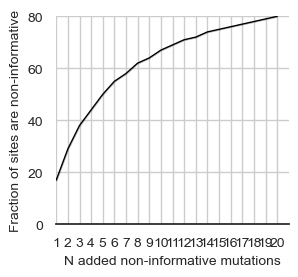

In [75]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    ax = sns.lineplot(data=performance, x="n_ni_pos", y="n_ni_pos_frac", lw=1, color='black') #ci=None
    ax.set_ylim(0, 80)
    ax.set_xlim(0, 20)
    plt.grid(axis='both')
    #tick = 4
    #[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % tick != 0]
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel('Fraction of sites are non-informative')
    plt.xlabel('N added non-informative mutations')
    
plt.savefig(f'../../data/simulated_figures/fraction_non-informative_sites_{exp}.svg', dpi=300, bbox_inches='tight', transparent=True)
plt.savefig(f'../../data/simulated_figures/fraction_non-informative_sites_{exp}.jpg', dpi=300, bbox_inches='tight', transparent=True)